In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_10_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_10_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 100     # 蒙特卡洛模拟次数
time_steps = 100           # 总时间步数
N = network_scale_1[0]     # 网络节点数
w_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    # S-I断边概率

# 1. SIS参数
bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([len(w_list), time_steps])
awareness_count_average_total = np.zeros([len(w_list), time_steps])

In [6]:
for w in w_list:
    
    time_start_w = time.time()
    
    random.seed(512)
    np.random.seed(512)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0


                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_, :] = infective_count_average/N
    awareness_count_average_total[iter_, :] = awareness_count_average/N
    iter_ += 1

    print("w = {} - time has passed: {} ".format(w, time.time()-time_start))

    loop 0 - time has passed: 54.18276834487915 
    loop 1 - time has passed: 102.95856642723083 
    loop 2 - time has passed: 161.75139999389648 
    loop 3 - time has passed: 219.81771731376648 
    loop 4 - time has passed: 271.4628484249115 
    loop 5 - time has passed: 320.6617257595062 
    loop 6 - time has passed: 368.55427837371826 
    loop 7 - time has passed: 459.8807590007782 
    loop 8 - time has passed: 507.8633487224579 
    loop 9 - time has passed: 554.3989222049713 
    loop 10 - time has passed: 599.7430989742279 
    loop 11 - time has passed: 644.6661376953125 
    loop 12 - time has passed: 689.1301250457764 
    loop 13 - time has passed: 733.9930291175842 
    loop 14 - time has passed: 779.2264683246613 
    loop 15 - time has passed: 823.442732334137 
    loop 16 - time has passed: 869.239180803299 
    loop 17 - time has passed: 914.227062702179 
    loop 18 - time has passed: 958.821391582489 
    loop 19 - time has passed: 1003.3687701225281 
    loop 

    loop 63 - time has passed: 3173.0816950798035 
    loop 64 - time has passed: 3218.598774909973 
    loop 65 - time has passed: 3265.3074185848236 
    loop 66 - time has passed: 3311.7377259731293 
    loop 67 - time has passed: 3357.3469364643097 
    loop 68 - time has passed: 3403.094220161438 
    loop 69 - time has passed: 3448.660305738449 
    loop 70 - time has passed: 3531.0182898044586 
    loop 71 - time has passed: 3577.37749004364 
    loop 72 - time has passed: 3623.784381389618 
    loop 73 - time has passed: 3670.4251635074615 
    loop 74 - time has passed: 3716.19061422348 
    loop 75 - time has passed: 3761.7999482154846 
    loop 76 - time has passed: 3808.080934047699 
    loop 77 - time has passed: 3888.8454813957214 
    loop 78 - time has passed: 3934.0789535045624 
    loop 79 - time has passed: 3979.519502401352 
    loop 80 - time has passed: 4025.73872423172 
    loop 81 - time has passed: 4072.3404047489166 
    loop 82 - time has passed: 4118.4515473

    loop 25 - time has passed: 1284.155974149704 
    loop 26 - time has passed: 1333.5456473827362 
    loop 27 - time has passed: 1383.4990615844727 
    loop 28 - time has passed: 1432.5763249397278 
    loop 29 - time has passed: 1480.9216496944427 
    loop 30 - time has passed: 1529.5460143089294 
    loop 31 - time has passed: 1579.4991040229797 
    loop 32 - time has passed: 1627.1236371994019 
    loop 33 - time has passed: 1675.0616402626038 
    loop 34 - time has passed: 1724.510859966278 
    loop 35 - time has passed: 1773.3118152618408 
    loop 36 - time has passed: 1822.6085197925568 
    loop 37 - time has passed: 1871.3108069896698 
    loop 38 - time has passed: 1920.249957561493 
    loop 39 - time has passed: 1970.702607870102 
    loop 40 - time has passed: 2020.7959384918213 
    loop 41 - time has passed: 2070.39014005661 
    loop 42 - time has passed: 2118.827671289444 
    loop 43 - time has passed: 2168.3177704811096 
    loop 44 - time has passed: 2217.39

    loop 87 - time has passed: 4547.858751773834 
    loop 88 - time has passed: 4601.093294620514 
    loop 89 - time has passed: 4653.109259843826 
    loop 90 - time has passed: 4706.297072172165 
    loop 91 - time has passed: 4758.109364271164 
    loop 92 - time has passed: 4810.468366861343 
    loop 93 - time has passed: 4861.640182971954 
    loop 94 - time has passed: 4913.359649896622 
    loop 95 - time has passed: 4964.7028431892395 
    loop 96 - time has passed: 5015.714115381241 
    loop 97 - time has passed: 5067.625107765198 
    loop 98 - time has passed: 5119.125143527985 
    loop 99 - time has passed: 5170.625804424286 
w = 0.4 - time has passed: 5170.672681808472 
    loop 0 - time has passed: 52.74950575828552 
    loop 1 - time has passed: 107.40553450584412 
    loop 2 - time has passed: 162.03026819229126 
    loop 3 - time has passed: 214.6400966644287 
    loop 4 - time has passed: 295.63943552970886 
    loop 5 - time has passed: 377.58894395828247 
    l

    loop 49 - time has passed: 3052.199711561203 
    loop 50 - time has passed: 3108.1411123275757 
    loop 51 - time has passed: 3163.823221206665 
    loop 52 - time has passed: 3247.2538843154907 
    loop 53 - time has passed: 3305.286451816559 
    loop 54 - time has passed: 3362.7675879001617 
    loop 55 - time has passed: 3446.2208256721497 
    loop 56 - time has passed: 3501.7217910289764 
    loop 57 - time has passed: 3562.252060174942 
    loop 58 - time has passed: 3619.815932750702 
    loop 59 - time has passed: 3677.1117255687714 
    loop 60 - time has passed: 3761.6852486133575 
    loop 61 - time has passed: 3818.4561405181885 
    loop 62 - time has passed: 3874.5385403633118 
    loop 63 - time has passed: 3930.3856360912323 
    loop 64 - time has passed: 3987.801572561264 
    loop 65 - time has passed: 4045.135910511017 
    loop 66 - time has passed: 4102.157923221588 
    loop 67 - time has passed: 4158.670804262161 
    loop 68 - time has passed: 4214.7990

    loop 11 - time has passed: 807.8548057079315 
    loop 12 - time has passed: 891.591489315033 
    loop 13 - time has passed: 960.8752598762512 
    loop 14 - time has passed: 1028.064265012741 
    loop 15 - time has passed: 1095.0629284381866 
    loop 16 - time has passed: 1178.453855752945 
    loop 17 - time has passed: 1244.1728024482727 
    loop 18 - time has passed: 1305.6849806308746 
    loop 19 - time has passed: 1372.37460398674 
    loop 20 - time has passed: 1435.8606338500977 
    loop 21 - time has passed: 1502.2348940372467 
    loop 22 - time has passed: 1566.5144052505493 
    loop 23 - time has passed: 1630.5789177417755 
    loop 24 - time has passed: 1696.2823948860168 
    loop 25 - time has passed: 1761.198000907898 
    loop 26 - time has passed: 1825.8919496536255 
    loop 27 - time has passed: 1890.9226620197296 
    loop 28 - time has passed: 1959.5902526378632 
    loop 29 - time has passed: 2023.2514622211456 
    loop 30 - time has passed: 2090.1112

    loop 73 - time has passed: 5340.952037572861 
    loop 74 - time has passed: 5411.515246152878 
    loop 75 - time has passed: 5487.793323278427 
    loop 76 - time has passed: 5562.620397806168 
    loop 77 - time has passed: 5634.296810865402 
    loop 78 - time has passed: 5704.062636137009 
    loop 79 - time has passed: 5772.404993057251 
    loop 80 - time has passed: 5843.2808475494385 
    loop 81 - time has passed: 5912.779732465744 
    loop 82 - time has passed: 5984.758432388306 
    loop 83 - time has passed: 6058.165318012238 
    loop 84 - time has passed: 6131.880045413971 
    loop 85 - time has passed: 6199.471196174622 
    loop 86 - time has passed: 6269.031761407852 
    loop 87 - time has passed: 6339.534424781799 
    loop 88 - time has passed: 6411.360702991486 
    loop 89 - time has passed: 6484.093220710754 
    loop 90 - time has passed: 6567.349815368652 
    loop 91 - time has passed: 6639.844683885574 
    loop 92 - time has passed: 6712.7194356918335

In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../results/'
name1 = 'WS_WS_w_infective'
name2 = 'WS_WS_w_awareness'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

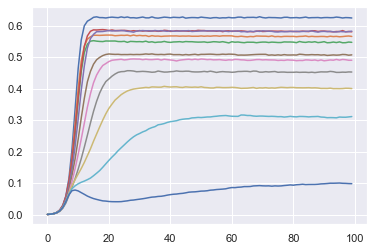

In [9]:
for w_ in range(len(w_list)):
    plt.plot(infective_count_average_total[w_,:], label=str(w_list[w_]))